In [1]:
# grid search sarima hyperparameters for daily female dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import matplotlib.pylab as plt

In [2]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [3]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [4]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	print('walk_forward_validation') 
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error


In [5]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	print('score_model')  
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)
 

In [6]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	print('grid_search')
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [7]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	print('sarima_configs')
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [8]:
# load dataset
'''
series = read_csv('./input/shampoo.csv', header=0, index_col=0)
data = series.values
print(data.shape)
# data split
n_test = 165
# model configs
print('running')
cfg_list = sarima_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
	print(cfg, error)
'''

"\nseries = read_csv('./input/shampoo.csv', header=0, index_col=0)\ndata = series.values\nprint(data.shape)\n# data split\nn_test = 165\n# model configs\nprint('running')\ncfg_list = sarima_configs()\n# grid search\nscores = grid_search(data, cfg_list, n_test)\nprint('done')\n# list top 3 configs\nfor cfg, error in scores[:3]:\n\tprint(cfg, error)\n"

In [9]:
#print(data.shape)

In [10]:
#https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
#Stationarity (Differencing and Augmented Dickey-Fuller Test)

# load dataset
#series = read_csv('./input/shampoo.csv', header=0, index_col=0)
series = read_csv('p01_steps.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
data = series.values

X = series.values.astype('float32')
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(train)

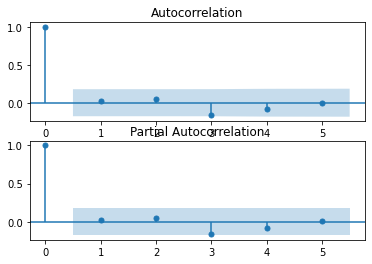

In [11]:
#SARIMA Model Parameters — ACF and PACF Plots

'''
As a quick overview, SARIMA models are ARIMA models with a seasonal component. Per the formula SARIMA(p,d,q)x(P,D,Q,s), the parameters for these types of models are as follows:
p and seasonal P: indicate number of autoregressive terms (lags of the stationarized series)
d and seasonal D: indicate differencing that must be done to stationarize series
q and seasonal Q: indicate number of moving average terms (lags of the forecast errors)
s: indicates seasonal length in the data
'''

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(train, lags=5, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train, lags=5, ax=ax[1])
plt.show()

In [12]:
'''
As can be seen, there are significant negative spikes in the ACF plot at lag 1 and lag 7 (weekly seasonal component). 
In the PACF plot, there are significant negative spikes at lags 1 and 2 (i.e. lags are slower to decay), 
as well as significant negative spikes at lags 7, 14, 21, etc.

These characteristics suggest a potential parameter starting point of SARIMA(0,1,1)x(0,1,1,7):
p and P both equal 0 (no significant positive spikes in ACF and PACF plots)
d and D both equal 1 (first difference and seasonal difference)
q and Q both equal 1 (significant negative spikes, PACF decay is more gradual)
s equal to 7 (weekly seasonal component)
'''

#Grid Search and AIC

#model = sm.tsa.statespace.SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,7))

#model.fit(max_iter = 10, method='powell')


'\nAs can be seen, there are significant negative spikes in the ACF plot at lag 1 and lag 7 (weekly seasonal component). \nIn the PACF plot, there are significant negative spikes at lags 1 and 2 (i.e. lags are slower to decay), \nas well as significant negative spikes at lags 7, 14, 21, etc.\n\nThese characteristics suggest a potential parameter starting point of SARIMA(0,1,1)x(0,1,1,7):\np and P both equal 0 (no significant positive spikes in ACF and PACF plots)\nd and D both equal 1 (first difference and seasonal difference)\nq and Q both equal 1 (significant negative spikes, PACF decay is more gradual)\ns equal to 7 (weekly seasonal component)\n'

In [13]:
#SARIMA Model Parameters — Grid Search

import itertools
import math 

#set parameter range
#p = range(0,4)
#q = range(1,4)
#d = range(1,4)
p = [0, 10]
d = [2]
q = [4]
s = range(1,12)

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))

# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 10, method = 'powell')
            
            print('SARIMA{},{} - AIC:{} - RMSE:{}'.format(param, param_seasonal, results.aic, math.sqrt(results.mse)))
        except:
            continue

c:\users\ayanc\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\ayanc\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 8.966230
         Iterations: 5
         Function evaluations: 609
SARIMA(0, 2, 4),(0, 2, 4, 5) - AIC:2187.8275916636703 - RMSE:6500.113026664219
Optimization terminated successfully.
         Current function value: 8.796278
         Iterations: 5
         Function evaluations: 543
SARIMA(0, 2, 4),(0, 2, 4, 6) - AIC:2146.699227802893 - RMSE:6267.746310421296
Optimization terminated successfully.
         Current function value: 8.593041
         Iterations: 5
         Function evaluations: 592
SARIMA(0, 2, 4),(0, 2, 4, 7) - AIC:2097.515879493107 - RMSE:5981.263081906526
Optimization terminated successfully.
         Current function value: 8.477771
         Iterations: 4
         Function evaluations: 446
SARIMA(0, 2, 4),(0, 2, 4, 8) - AIC:2069.620631601961 - RMSE:6364.666050526864


c:\users\ayanc\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 8.341015
         Iterations: 5
         Function evaluations: 595
SARIMA(0, 2, 4),(0, 2, 4, 9) - AIC:2036.5256476253583 - RMSE:6407.732061363133
Optimization terminated successfully.
         Current function value: 8.180410
         Iterations: 5
         Function evaluations: 531
SARIMA(0, 2, 4),(0, 2, 4, 10) - AIC:1997.6593406729046 - RMSE:6500.313805292858
Optimization terminated successfully.
         Current function value: 7.983189
         Iterations: 4
         Function evaluations: 483
SARIMA(0, 2, 4),(0, 2, 4, 11) - AIC:1949.9318350606745 - RMSE:6430.140869694628


c:\users\ayanc\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Optimization terminated successfully.
         Current function value: 8.936147
         Iterations: 9
         Function evaluations: 2012
SARIMA(0, 2, 4),(10, 2, 4, 5) - AIC:2200.547482021062 - RMSE:6365.049383028675
Optimization terminated successfully.
         Current function value: 8.770684
         Iterations: 8
         Function evaluations: 1812
SARIMA(0, 2, 4),(10, 2, 4, 6) - AIC:2160.5055617475664 - RMSE:6185.533016381511
Optimization terminated successfully.
         Current function value: 8.527757
         Iterations: 10
         Function evaluations: 2269
SARIMA(0, 2, 4),(10, 2, 4, 7) - AIC:2101.7171930108548 - RMSE:5756.554049601833
Optimization terminated successfully.
         Current function value: 8.443648
         Iterations: 5
         Function evaluations: 1151
SARIMA(0, 2, 4),(10, 2, 4, 8) - AIC:2081.3627075679206 - RMSE:6308.174782857691
Optimization terminated successfully.
         Current function value: 8.277200
         Iterations: 5
         Function eva

c:\users\ayanc\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Optimization terminated successfully.
         Current function value: 8.982905
         Iterations: 12
         Function evaluations: 2677
SARIMA(10, 2, 4),(0, 2, 4, 5) - AIC:2211.8630712178997 - RMSE:6546.547221124622
Optimization terminated successfully.
         Current function value: 8.797568
         Iterations: 9
         Function evaluations: 2041
SARIMA(10, 2, 4),(0, 2, 4, 6) - AIC:2167.0115429616385 - RMSE:6234.783343159538
Optimization terminated successfully.
         Current function value: 8.537909
         Iterations: 15
         Function evaluations: 3400
SARIMA(10, 2, 4),(0, 2, 4, 7) - AIC:2104.174033137397 - RMSE:5813.101076898752
Optimization terminated successfully.
         Current function value: 8.449073
         Iterations: 15
         Function evaluations: 3481
SARIMA(10, 2, 4),(0, 2, 4, 8) - AIC:2082.6755510324265 - RMSE:6262.373633501809
Optimization terminated successfully.
         Current function value: 8.344470
         Iterations: 7
         Function e

In [14]:
#Walk Forward Validation & Evaluation with MAPE

# data = entire dataset
# n_test = point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    mape_list = []
    train, test = data[:n_test], data[n_test:]
    day_list = [7,14,21,28] # weeks 1,2,3,4
    for i in day_list:
        # Fit model to training data
        model = sm.tsa.statespace.SARIMAX(train, order=(1,1,2), 
                                          seasonal_order = (1,1,2,7))                                          
            
        model = model.fit(max_iter = 10, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model.get_forecast(steps = 7)
        predictions = np.concatenate(predictions, forecast, 
                                     axis=None)
        
        # Calculate MAPE and add to mape_list
        j = i-7
        mape_score = (abs(test[j:i]-predictions[j:i])/test[j:i])*100
        mape_mean = mape_score.mean()
        mape_list.append(mape_mean)
        
        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
        
    return predictions, mape_list

In [15]:
'''
For many types of time series models, it’s important to verify that your data is stationary. 
As a quick summary, the data needs to satisfy the following requirements to ensure stationarity:

Constant mean
Constant variance
Constant autocorrelation structure (current value being dependent on past value)
No periodic component
'''

'\nFor many types of time series models, it’s important to verify that your data is stationary. \nAs a quick summary, the data needs to satisfy the following requirements to ensure stationarity:\n\nConstant mean\nConstant variance\nConstant autocorrelation structure (current value being dependent on past value)\nNo periodic component\n'